In [1]:
import sys
import os
import json
sys.path.append(os.path.abspath(".."))
from reasonable_crowd.parse_trajectory import parse_trajectory
from reasonable_crowd.parse_map import parse_map
from rulebook_benchmark.process_trajectory import process_trajectory

from concurrent.futures import ThreadPoolExecutor, as_completed
import os
from tqdm import tqdm

from rulebook_benchmark.rulebook import Relation
from tqdm.notebook import tqdm
import cProfile, pstats
path_to_reasonable_crowd = "../../../Reasonable-Crowd"
map_directory = path_to_reasonable_crowd + '/maps'
trajectory_directory = path_to_reasonable_crowd + '/trajectories'

network_U = parse_map(map_directory, 'U')
network_S = parse_map(map_directory, 'S')

output_directory = 'outputs'
output_file = os.path.join(output_directory, 'results_scenic.txt')
'''
# First loop: parse and process trajectories, store them in a list
trajectories = []
trajectory_files = [f for f in os.listdir(trajectory_directory) if f.endswith('.json')]
pbar = tqdm(total=len(trajectory_files), leave=False)
for filename in trajectory_files:
    traj_path = os.path.join(trajectory_directory, filename)
    if filename.startswith('U'):
        pbar.set_description(f"Parsing and processing trajectory {filename} on map U")
        realization = parse_trajectory(traj_path, step_size=100000)
        realization.network = network_U
    else:
        pbar.set_description(f"Parsing and processing trajectory {filename} on map S")
        realization = parse_trajectory(traj_path, step_size=100000)
        realization.network = network_S
    #process_trajectory(realization)
    trajectories.append((filename, realization))
    pbar.update(1)
pbar.close()


'''







/Users/ekin/Scenic/src/scenic/core/errors.py:271: UserWarning: unable to install sys.excepthook to format Scenic backtraces
  warnings.warn("unable to install sys.excepthook to format Scenic backtraces")


'\n# First loop: parse and process trajectories, store them in a list\ntrajectories = []\ntrajectory_files = [f for f in os.listdir(trajectory_directory) if f.endswith(\'.json\')]\npbar = tqdm(total=len(trajectory_files), leave=False)\nfor filename in trajectory_files:\n    traj_path = os.path.join(trajectory_directory, filename)\n    if filename.startswith(\'U\'):\n        pbar.set_description(f"Parsing and processing trajectory {filename} on map U")\n        realization = parse_trajectory(traj_path, step_size=100000)\n        realization.network = network_U\n    else:\n        pbar.set_description(f"Parsing and processing trajectory {filename} on map S")\n        realization = parse_trajectory(traj_path, step_size=100000)\n        realization.network = network_S\n    #process_trajectory(realization)\n    trajectories.append((filename, realization))\n    pbar.update(1)\npbar.close()\n\n\n'

In [2]:
def _parse_single_file(filename, trajectory_directory, network_U, network_S, step_size):
    traj_path = os.path.join(trajectory_directory, filename)
    if filename.startswith('U'):
        realization = parse_trajectory(traj_path, step_size=step_size)
        realization.network = network_U
    else:
        realization = parse_trajectory(traj_path, step_size=step_size)
        realization.network = network_S
        
    process_trajectory(realization)
    return filename, realization

def load_all_trajectories(trajectory_directory, network_U, network_S, step_size=100000, max_workers=8):
    trajectory_files = [f for f in os.listdir(trajectory_directory) if f.endswith('.json')]
    trajectories = []

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {
            executor.submit(_parse_single_file, f, trajectory_directory, network_U, network_S, step_size): f
            for f in trajectory_files
        }

        with tqdm(total=len(futures), leave=False) as pbar:
            for future in as_completed(futures):
                filename, realization = future.result()
                trajectories.append((filename, realization))
                pbar.set_description(f"Parsing {filename}")
                pbar.update(1)

    return trajectories

In [3]:
import pickle


# check if trajectories.pkl exists
if os.path.exists(os.path.join(output_directory, 'trajectories.pkl')):
    with open(os.path.join(output_directory, 'trajectories.pkl'), 'rb') as f:
        trajectories = pickle.load(f)
else:
    profiler = cProfile.Profile()
    profiler.enable()
    trajectories = load_all_trajectories(
        trajectory_directory,
        network_U,
        network_S,
        step_size=100000,
    max_workers=8   # adjust depending on your CPU
)
    with open(os.path.join(output_directory, 'trajectories.pkl'), 'wb') as f:
        pickle.dump(trajectories, f)
        
        
    profiler.disable()
    stats = pstats.Stats(profiler).sort_stats("cumtime")
    stats.print_stats(30)  # top 30 slowest calls

  0%|          | 0/576 [00:00<?, ?it/s]

         1432328 function calls (1430693 primitive calls) in 482.917 seconds

   Ordered by: cumulative time
   List reduced from 569 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.003    0.003  463.384  463.384 /var/folders/08/4xhb8kqd27qggxbyxp4t9g3w0000gn/T/ipykernel_12642/3461841543.py:13(load_all_trajectories)
      583    0.002    0.000  458.906    0.787 /opt/anaconda3/envs/benchmark/lib/python3.8/threading.py:540(wait)
     1156    0.003    0.000  458.904    0.397 /opt/anaconda3/envs/benchmark/lib/python3.8/threading.py:270(wait)
     6757  458.901    0.068  458.901    0.068 {method 'acquire' of '_thread.lock' objects}
      577    0.004    0.000  458.838    0.795 /opt/anaconda3/envs/benchmark/lib/python3.8/concurrent/futures/_base.py:200(as_completed)
        1   19.399   19.399   19.532   19.532 {built-in method _pickle.dump}
        1    0.000    0.000    2.871    2.871 /opt/anaconda3/envs/benchmark/lib/py

In [4]:
trajectories_dict = {}
for filename, realization in trajectories:
    trajectories_dict[filename[:-5]] = realization  # remove .json extension

In [5]:
from rulebook_benchmark.realization import VariableHandler
from rulebook_benchmark.rule_functions import RuleEngine
from rulebook_benchmark.rule_functions import (
    f1, f2, f3, f4, f5, f6, f7, f8, f9, f11, f12, f13, f15, f17, f18, Result
)

In [6]:


ruleset = {"vru_collision": f1, "vehicle_collision": f2, "drivable_area": f3, "vru_ttc": f4, "vru_acknowledgement": f5, "vehicle_ttc": f6, "correct_side": f7, "vru_offroad": f8, "vru_onroad": f9, "front_clearance_buffer": f11, "left_clearance_buffer": f12, "right_clearance_buffer": f13, "speed_limit": f15, "lane_keeping": f17, "lane_centering": f18}



def get_rule_violations(realization):

    handler = VariableHandler(realization)
    rule_engine = RuleEngine(ruleset)

    # Evaluate rules
    results = rule_engine.evaluate(handler)

    return results
    results = {}
    identity_result = Result()
    results['vru_collision'] = f1(realization)
    results['vehicle_collision'] = f2(realization)
    results['drivable_area'] = f3(realization)
    #results['vru_ttc'] = f4(realization)
    results['vru_ttc'] = identity_result
    results['vru_acknowledgement'] = identity_result
    results['vehicle_ttc'] = identity_result
    #results['vru_acknowledgement'] = f5(realization, proximity = 5, threshold = -1, steps = 30)
    #results['vehicle_ttc'] = f6(realization)
    results['correct_side'] = f7(realization)
    results['vru_offroad'] = f8(realization, threshold = 1)
    results['vru_onroad'] = f9(realization, threshold = 1)
    results['front_clearance_buffer'] = f11_a(realization, proximity = 5, threshold = 0.8)
    results['left_clearance_buffer'] = f12_a(realization, proximity = 5, threshold = 0.8)
    results['right_clearance_buffer'] = f13_a(realization, proximity = 5, threshold = 0.8)
    results['speed_limit'] = f15(realization)
    results['lane_keeping'] = f17(realization)
    results['lane_centering'] = f18(realization)
    
    return results



# Collect evaluation results




f = open(output_file, 'w')
# Second loop: evaluate and write results
pbar = tqdm(total=len(trajectories), desc="Evaluating trajectories", leave=False)
for filename, realization in trajectories:
    results = get_rule_violations(realization)
    f.write(f"{filename}")
    for _, result in results.items():
        f.write(f" {result.total_violation}")
    pbar.update(1)
    f.write("\n")
pbar.close()        

f.close()



Evaluating trajectories:   0%|          | 0/576 [00:00<?, ?it/s]

/opt/anaconda3/envs/benchmark/lib/python3.8/site-packages/shapely/measurement.py:72: RuntimeWarning: overflow encountered in distance
  return lib.distance(a, b, **kwargs)
/opt/anaconda3/envs/benchmark/lib/python3.8/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


In [ ]:
from IPython.display import display, HTML
from pprint import pprint
from rulebook_benchmark.rulebook import Rulebook
from networkx import topological_sort
# Compare with human annotations

rb = Rulebook(rule_file="reasonable_crowd_rule_functions.py", rulebook_file="reasonable_crowd_4.graph")

rule_id_to_name = {1: "vru_collision", 2: "vehicle_collision", 3: "drivable_area", 4: "vru_ttc", 5: "vru_acknowledgement", 6: "vehicle_ttc", 7:"correct_side", 8: "vru_offroad", 9: "vru_onroad", 11: "front_clearance_buffer", 12: "left_clearance_buffer", 13: "right_clearance_buffer", 15: "speed_limit", 17: "lane_keeping", 18: "lane_centering"}
rule_name_to_id = {v: k for k, v in rule_id_to_name.items()}
rule_id_to_rule = {rule_id: ruleset[rule_name] for rule_id, rule_name in rule_id_to_name.items()}

idx_to_rule_id = list(rule_id_to_name.keys())
rule_id_to_idx = {rule_id: idx for idx, rule_id in enumerate(idx_to_rule_id)}
sorted_rule_ids = list(topological_sort(rb.priority_graph))
rule_names = list(rule_id_to_name.values())
results = {}
dataset = []

wrong_reasons = {rule: 0 for rule in rule_names}
correct_reasons = {rule: 0 for rule in rule_names}

with open(output_file, 'r') as f:
    for line in f:
        parts = line.strip().split()
        filename = parts[0].split(".")[0]
        results[filename] = list(map(float, parts[1:]))
f.close()

incorrect = []

correct = 0
total = 0
weighted_correct = 0
weighted_total = 0

human_euqal_count = 0
human_non_equal_count = 0
model_equal_count = 0
model_non_equal_count = 0
model_non_comparable_count = 0

annotation_file = os.path.join(path_to_reasonable_crowd, "annotations/annotations.json")
with open(annotation_file, 'r') as f:
    data = json.load(f)
f.close()

#print(len(data.items()))
for scenario, annotations in data.items():
    #print(len(annotations.items()))
    evaluated_pairs = set()
    for pair, votes in list(annotations.items()):
        t1, t2 = pair.split(" ;; ")
        reverse_pair = f"{t2} ;; {t1}"
        reverse_votes = annotations.get(reverse_pair, [])
        if pair in evaluated_pairs or reverse_pair in evaluated_pairs:
            continue
        if not (t1 in results and t2 in results):
            continue
        evaluated_pairs.add(pair)
        evaluated_pairs.add(reverse_pair)
        
        votes_1 = len(votes)
        votes_2 = len(reverse_votes)
        votes_total = votes_1 + votes_2
        
        if votes_1 > votes_2:
            human_pref = Relation.LARGER
            human_non_equal_count += 1
            dataset.append((t1,t2, 0))
        elif votes_1 < votes_2:
            human_pref = Relation.SMALLER
            human_non_equal_count += 1
            dataset.append((t1,t2, 1))
        else:
            human_pref = Relation.EQUAL
            human_euqal_count += 1
        
        model_pref = rb.compare_trajectories((t1, results), (t2, results))
        if model_pref == Relation.EQUAL:
            model_equal_count += 1
        elif model_pref == Relation.NONCOMPARABLE:
            model_non_comparable_count += 1
        else:
            model_non_equal_count += 1
        
        if model_pref == Relation.EQUAL or model_pref == Relation.NONCOMPARABLE or human_pref == Relation.EQUAL:
            continue
        is_correct = (human_pref == model_pref)
        correct += int(is_correct)
        total += 1
        if not is_correct:
            
            #pprint(f"Error in {scenario}: {pair} - Model: {model_pref}, Human: {human_pref}")
            #pprint(f"t1: {list(zip(rule_names, results[t1]))}")
            #pprint(f"t2: {list(zip(rule_names, results[t2]))}")
            for rule_id in sorted_rule_ids:
                if rule_id in rb.rule_ids:
                    idx = rule_id_to_idx[rule_id]
                    r1 = results[t1][idx]
                    r2 = results[t2][idx]
                    if r1 != r2:
                        reason = (rule_names[idx], r1, r2)
                        #pprint(reason)
                        wrong_reasons[reason[0]] += 1
                        if human_pref == Relation.LARGER:
                            incorrect.append((reason[0], t1, t2))
                        else:
                            incorrect.append((reason[0], t2, t1))
                        break
        else:                
            for rule_id in sorted_rule_ids:
                if rule_id in rb.rule_ids:
                    idx = rule_id_to_idx[rule_id]
                    r1 = results[t1][idx]
                    r2 = results[t2][idx]
                    if r1 != r2:
                        reason = (rule_names[idx], r1, r2)
                        correct_reasons[reason[0]] += 1
                        break


            # print the name of the rule that caused the preference

            

        weighted_correct += votes_1 if is_correct and human_pref == Relation.LARGER else 0
        weighted_correct += votes_2 if is_correct and human_pref == Relation.SMALLER else 0
        weighted_total += max(votes_1, votes_2)


import numpy as np
dataset = np.array(dataset)

print(human_non_equal_count, correct)

print("Accuracy:")
print("Pairwise accuracy:", correct / total if total > 0 else 0)
print("Weighted accuracy:", weighted_correct / weighted_total if weighted_total > 0 else 0)
print("Total pairs:", total)
print("Total weighted pairs:", weighted_total)

print("\nStatistics:")
print("Model discernment:", model_non_equal_count / (model_equal_count + model_non_equal_count + model_non_comparable_count))
print("Human discernment:", human_non_equal_count / (human_euqal_count + human_non_equal_count))
print("Human equal count:", human_euqal_count)
print("Human non-equal count:", human_non_equal_count)
print("Model equal count:", model_equal_count)
print("Model non-equal count:", model_non_equal_count)
print("Model non-comparable count:", model_non_comparable_count)



# Example usage:
# print_small("your output text here")


1641 1267
Accuracy:
Pairwise accuracy: 0.7840346534653465
Weighted accuracy: 0.7974605712177576
Total pairs: 1616
Total weighted pairs: 32527

Statistics:
Model discernment: 0.9833531510107015
Human discernment: 0.9756242568370987
Human equal count: 41
Human non-equal count: 1641
Model equal count: 7
Model non-equal count: 1654
Model non-comparable count: 21


In [8]:
#rb.priority_graph.
import networkx as nx
nx.ancestors(rb.priority_graph, 4)
neighbors = rb.priority_graph.neighbors(4)
rb.priority_graph.in_edges(4)

InEdgeDataView([(17, 4)])

In [9]:
import numpy as np

# Count number of '0's and '1's in the third column of dataset
num_zeros = np.sum(dataset[:, 2] == '0')
num_ones = np.sum(dataset[:, 2] == '1')

print(f"Number of 0s: {num_zeros}")
print(f"Number of 1s: {num_ones}")

Number of 0s: 818
Number of 1s: 823


In [41]:
class InPlaceRulebook:
    def __init__(self, priority_graph, rule_id_to_rule):
        # copy the priority graph structure
        self.in_place_priority_graph = nx.DiGraph()
        for node in priority_graph.nodes(data=True):
            self.in_place_priority_graph.add_node(node[0], rule=rule_id_to_rule[node[0]])
        for edge in priority_graph.edges(data=True):
            self.in_place_priority_graph.add_edge(edge[0], edge[1])
            
        self.root_node = list(nx.topological_sort(self.in_place_priority_graph))[0]
            
    def compare_trajectories(self, realization1, realization2):
        handler1 = VariableHandler(realization1)
        handler2 = VariableHandler(realization2)
        
        return self._compare_trajectories(self.root_node, handler1, handler2)[0]
            
    def _compare_trajectories(self, rule_id, handler1, handler2):
        rule = self.in_place_priority_graph.nodes[rule_id]['rule']
        result1 = rule.evaluate(handler1)
        result2 = rule.evaluate(handler2)

        
        if result1 < result2:
            return (0, rule_id)
        elif result1 > result2:
            return (1, rule_id)
        elif self.in_place_priority_graph.out_degree(rule_id) == 0:
            return (2, rule_id)
        else:

            results = {self._compare_trajectories(n, handler1, handler2) for n in self.in_place_priority_graph.successors(rule_id)}
            if all(r[0] == 0 for r in results):
                return (0, rule_id)
            elif all(r[0] == 1 for r in results):
                return (1, rule_id)
            elif all(r[0] == 2 for r in results):
                return (2, rule_id)
            else:
                return (-1, rule_id)
        
        
    def get_rule_relation(self, id1, id2):
        if nx.has_path(self.in_place_priority_graph, id1, id2):
            return Relation.LARGER
        elif nx.has_path(self.in_place_priority_graph, id2, id1):
            return Relation.SMALLER
        else:
            return Relation.NONCOMPARABLE
        
            
def evaluate_rulebook(rulebook, arr):
    correct = 0
    incorrect = 0
    equal = 0
    incomparable = 0
    total = len(arr)
    pbar = tqdm(total=len(arr), desc="Evaluating rulebook", leave=False)
    for t1, t2, label in arr:
        r1 = trajectories_dict[t1]
        r2 = trajectories_dict[t2]
        model_pref = rulebook.compare_trajectories(r1, r2)
        label = int(label)
        if model_pref == label:
            correct += 1
        if model_pref != label:
            incorrect += 1
        if model_pref == 2:
            equal += 1
        if model_pref == -1:
            incomparable += 1
            
        pbar.update(1)
    pbar.close()
    return correct, incorrect, equal, incomparable, total
            
            

In [42]:
rbook = InPlaceRulebook(rb.priority_graph, rule_id_to_rule)
evaluate_rulebook(rbook, dataset)

Evaluating rulebook:   0%|          | 0/1641 [00:00<?, ?it/s]

(1213, 428, 5, 117, 1641)

In [43]:
def get_rule_params(rule_id, ruleset, rule_id_to_params, rule_id_to_name):
    """
    Get the current parameters for a given rule.
    """
    rule_name = rule_id_to_name[rule_id]
    rule_fn = ruleset[rule_name]
    param_names = rule_id_to_params[rule_id]
    return {p: rule_fn.parameters[p] for p in param_names}


def set_rule_params(rule_id, param_values, ruleset, rule_id_to_params, rule_id_to_name):
    """
    Set new parameters for a given rule.
    """
    rule_name = rule_id_to_name[rule_id]
    rule_fn = ruleset[rule_name]
    param_names = rule_id_to_params[rule_id]

    for p in param_names:
        if p in param_values:
            rule_fn.parameters[p] = param_values[p]




def evaluate_rule(rule, arr):
    rule_engine = RuleEngine({"tuned_rule": rule})
    correct = 0
    remaining = []
    # use tqdm
    pbar = tqdm(total=len(arr), desc="Evaluating rules", leave=False)
    for item in arr:
        t1, t2, label = item
        trajectory1 = trajectories_dict[t1]
        trajectory2 = trajectories_dict[t2]
        handler1 = VariableHandler(trajectory1)
        handler2 = VariableHandler(trajectory2)
        result1 = rule_engine.evaluate(handler1)
        result2 = rule_engine.evaluate(handler2)
        r1 = result1['tuned_rule'].total_violation
        r2 = result2['tuned_rule'].total_violation
        print(label, type(label))
        if r1 < r2 and label == '0':
            print("here")
            correct += 1
        elif r1 > r2 and label == '1':
            correct += 1
        else:
            remaining.append(item)
        pbar.update(1)
    pbar.close()
    return correct, np.array(remaining)



import itertools
import numpy as np

import itertools
import numpy as np

def optimize_rules_grid(
    ruleset,
    priority_order,
    rule_id_to_params,
    rule_id_to_name,
    rule_id_to_values,
    all_samples,
    rulebook,
    verbose=True,
):
    """
    Grid-search optimizer for rule parameters in priority order.
    - ruleset: dict(rule_name -> rule_object)
    - priority_order: list of rule_ids (highest -> lowest)
    - rule_id_to_params: dict rule_id -> [param_name, ...]
    - rule_id_to_name: dict rule_id -> rule_name
    - rule_id_to_values: {rule_id: {param_name: [list of candidate values]}}
    - evaluate_rule: callable(rule, samples) -> (correct_count, remaining_samples)
    - all_samples: array of tuples (t1, t2, label)
    - rulebook: Rulebook instance (must implement get_rule_relation)
    """
    best_config = {}
    rule_id_to_samples = {}
    first_node = priority_order[0]
    priority_graph = rulebook.priority_graph
    rule_id_to_samples[first_node] = all_samples

    for i, rule_id in enumerate(priority_order):
        current_samples = rule_id_to_samples[rule_id]
        rule_name = rule_id_to_name[rule_id]
        rule = ruleset[rule_name]

        if verbose:
            print(f"\n[optimize_rules_grid] Evaluating {rule_name} (id={rule_id})")

        param_names = rule_id_to_params.get(rule_id, [])
        value_lists = rule_id_to_values.get(rule_id, {})

        # Case 1: rule has tunable params → grid search
        if param_names and value_lists:
            best_rule_score = -1
            best_rule_params = None
            best_remaining = None

            for values in itertools.product(*(value_lists[p] for p in param_names)):
                trial_params = dict(zip(param_names, values))
                set_rule_params(rule_id, trial_params, ruleset, rule_id_to_params, rule_id_to_name)

                score, remaining = evaluate_rule(rule, current_samples)
                if score > best_rule_score:
                    best_rule_score = score
                    best_rule_params = trial_params
                    best_remaining = remaining

            # Commit best params
            set_rule_params(rule_id, best_rule_params, ruleset, rule_id_to_params, rule_id_to_name)
            best_config[rule_id] = best_rule_params
            remaining = best_remaining
            
            

            if verbose:
                print(f"  Best params: {best_rule_params}, score={best_rule_score}, remaining={len(remaining)}")

        # Case 2: no tunable params → just evaluate
        else:
            score, remaining = evaluate_rule(rule, current_samples)

            if verbose:
                print(f"  Fixed params, score={score}, remaining={len(remaining)}")
                
                
        neighbors = list(priority_graph.neighbors(rule_id))
        for neighbor in neighbors:
            if rule_id_to_samples.get(neighbor) is None:
                rule_id_to_samples[neighbor] = remaining
            else:
                rule_id_to_samples[neighbor] = np.vstack((rule_id_to_samples[neighbor], remaining)).unique(axis=0)
            print(neighbor)


    if verbose:
        print("\n[optimize_rules_grid] Optimization finished.")
        print("Best config by rule id:")
        for rid, params in best_config.items():
            print(f"  {rid} -> {params}")

    return best_config

In [36]:

sorted_rule_ids = list(topological_sort(rb.priority_graph))
rule_id_to_params = {4: ["threshold"], 6: ["threshold"], 8: ["threshold"], 9: ["threshold"], 5: ["velocity", "threshold", "timesteps"], 11: ["threshold"], 12: ["threshold"], 13: ["threshold"], 18: ["buffer"]}
rule_id_to_values = {4: {"threshold": [0.3, 0.5, 0.8, 1, 1.5]}, 6: {"threshold": [0.3, 0.5, 0.8, 1, 1.5]}, 8: {"threshold": [1, 1.5, 2, 2.5, 3]}, 9: {"threshold": [1, 1.5, 2, 2.5, 3]}, 5: {"velocity": [0, 1, 2, 3], "threshold": [-1, -0.5, -0.2, 0], "timesteps": [20, 30, 40]}, 11: {"threshold": [0.3, 0.5, 0.8, 1, 1.2]}, 12: {"threshold": [0.3, 0.5, 0.8, 1]}, 13: {"threshold": [0.3, 0.5, 0.8, 1]}, 18: {"buffer": [0.2, 0.3, 0.5, 0.8, 1]}}
tuning_file = os.path.join(output_directory, 'tuning.txt')


In [57]:
priority_graph = rb.priority_graph
priority_graph.nodes[1]['rules'][1]

In [38]:
print(len(dataset))

1641


In [40]:
import cProfile, pstats
profiler = cProfile.Profile()
profiler.enable()

best_config = optimize_rules_grid(
    ruleset,
    sorted_rule_ids,
    rule_id_to_params,
    rule_id_to_name,
    rule_id_to_values,
    dataset,
    rb,
    verbose=True,
)

profiler.disable()
stats = pstats.Stats(profiler).sort_stats("cumtime")
stats.print_stats(30)  # top 30 slowest calls


[optimize_rules_grid] Evaluating vru_collision (id=1)


Evaluating rules:   0%|          | 0/1641 [00:00<?, ?it/s]

  Fixed params, score=0, remaining=1641
2

[optimize_rules_grid] Evaluating vehicle_collision (id=2)


Evaluating rules:   0%|          | 0/1641 [00:00<?, ?it/s]

  Fixed params, score=294, remaining=1347
3

[optimize_rules_grid] Evaluating drivable_area (id=3)


Evaluating rules:   0%|          | 0/1347 [00:00<?, ?it/s]

  Fixed params, score=163, remaining=1184
7

[optimize_rules_grid] Evaluating correct_side (id=7)


Evaluating rules:   0%|          | 0/1184 [00:00<?, ?it/s]

  Fixed params, score=300, remaining=884
8
9

[optimize_rules_grid] Evaluating vru_offroad (id=8)


Evaluating rules:   0%|          | 0/884 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/884 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/884 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/884 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/884 [00:00<?, ?it/s]

  Best params: {'threshold': 3}, score=207, remaining=677
11

[optimize_rules_grid] Evaluating vru_onroad (id=9)


Evaluating rules:   0%|          | 0/884 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/884 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/884 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/884 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/884 [00:00<?, ?it/s]

  Best params: {'threshold': 3}, score=196, remaining=688
11

[optimize_rules_grid] Evaluating front_clearance_buffer (id=11)


Evaluating rules:   0%|          | 0/688 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/688 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/688 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/688 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/688 [00:00<?, ?it/s]

  Best params: {'threshold': 1.2}, score=79, remaining=609
12
13

[optimize_rules_grid] Evaluating left_clearance_buffer (id=12)


Evaluating rules:   0%|          | 0/609 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/609 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/609 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/609 [00:00<?, ?it/s]

  Best params: {'threshold': 1}, score=143, remaining=466
17

[optimize_rules_grid] Evaluating right_clearance_buffer (id=13)


Evaluating rules:   0%|          | 0/609 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/609 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/609 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/609 [00:00<?, ?it/s]

  Best params: {'threshold': 1}, score=163, remaining=446
17

[optimize_rules_grid] Evaluating lane_keeping (id=17)


Evaluating rules:   0%|          | 0/446 [00:00<?, ?it/s]

  Fixed params, score=131, remaining=315
4

[optimize_rules_grid] Evaluating vru_ttc (id=4)


Evaluating rules:   0%|          | 0/315 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/315 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/315 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/315 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/315 [00:00<?, ?it/s]

  Best params: {'threshold': 1.5}, score=40, remaining=275
5

[optimize_rules_grid] Evaluating vru_acknowledgement (id=5)


Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/275 [00:00<?, ?it/s]

  Best params: {'velocity': 0, 'threshold': -1, 'timesteps': 20}, score=26, remaining=249
6

[optimize_rules_grid] Evaluating vehicle_ttc (id=6)


Evaluating rules:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/249 [00:00<?, ?it/s]

  Best params: {'threshold': 1.5}, score=61, remaining=188
15

[optimize_rules_grid] Evaluating speed_limit (id=15)


Evaluating rules:   0%|          | 0/188 [00:00<?, ?it/s]

  Fixed params, score=0, remaining=188
18

[optimize_rules_grid] Evaluating lane_centering (id=18)


Evaluating rules:   0%|          | 0/188 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/188 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/188 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/188 [00:00<?, ?it/s]

Evaluating rules:   0%|          | 0/188 [00:00<?, ?it/s]

  Best params: {'buffer': 0.3}, score=134, remaining=54

[optimize_rules_grid] Optimization finished.
Best config by rule id:
  8 -> {'threshold': 3}
  9 -> {'threshold': 3}
  11 -> {'threshold': 1.2}
  12 -> {'threshold': 1}
  13 -> {'threshold': 1}
  4 -> {'threshold': 1.5}
  5 -> {'velocity': 0, 'threshold': -1, 'timesteps': 20}
  6 -> {'threshold': 1.5}
  18 -> {'buffer': 0.3}
         4386123503 function calls (4356657003 primitive calls) in 2175.274 seconds

   Ordered by: cumulative time
   List reduced from 489 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000 2175.272 1087.636 /opt/anaconda3/envs/benchmark/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3472(run_code)
        2    0.000    0.000 2175.272 1087.636 {built-in method builtins.exec}
        1    0.000    0.000 2175.272 2175.272 /var/folders/08/4xhb8kqd27qggxbyxp4t9g3w0000gn/T/ipykernel_2758/1645226332.py:5(<module>)
      

In [ ]:
pprint(correct_reasons)

{'correct_side': 270,
 'drivable_area': 153,
 'front_clearance_buffer': 57,
 'lane_centering': 53,
 'lane_keeping': 78,
 'left_clearance_buffer': 82,
 'right_clearance_buffer': 67,
 'speed_limit': 0,
 'vehicle_collision': 294,
 'vehicle_ttc': 18,
 'vru_acknowledgement': 5,
 'vru_collision': 0,
 'vru_offroad': 177,
 'vru_onroad': 1,
 'vru_ttc': 12}


In [ ]:
pprint(wrong_reasons)

{'correct_side': 56,
 'drivable_area': 41,
 'front_clearance_buffer': 19,
 'lane_centering': 10,
 'lane_keeping': 30,
 'left_clearance_buffer': 16,
 'right_clearance_buffer': 24,
 'speed_limit': 0,
 'vehicle_collision': 52,
 'vehicle_ttc': 5,
 'vru_acknowledgement': 7,
 'vru_collision': 0,
 'vru_offroad': 82,
 'vru_onroad': 0,
 'vru_ttc': 7}


In [ ]:
# Sum correct_reasons and wrong_reasons for each rule
total_reasons = {rule: correct_reasons[rule] + wrong_reasons[rule] for rule in rule_names}

# Calculate percentage of correctness for each rule
percentage_correct = {
    rule: (correct_reasons[rule] / total_reasons[rule] * 100 if total_reasons[rule] > 0 else -1)
    for rule in rule_names
}

# Sort percentage_correct from highest to lowest and display as a list of tuples
sorted_percentage = sorted(percentage_correct.items(), key=lambda item: item[1], reverse=True)
pprint(sorted_percentage)

[('vru_onroad', 100.0),
 ('vehicle_collision', 84.97109826589595),
 ('lane_centering', 84.12698412698413),
 ('left_clearance_buffer', 83.6734693877551),
 ('correct_side', 82.82208588957054),
 ('drivable_area', 78.8659793814433),
 ('vehicle_ttc', 78.26086956521739),
 ('front_clearance_buffer', 75.0),
 ('right_clearance_buffer', 73.62637362637363),
 ('lane_keeping', 72.22222222222221),
 ('vru_offroad', 68.33976833976834),
 ('vru_ttc', 63.1578947368421),
 ('vru_acknowledgement', 41.66666666666667),
 ('vru_collision', -1),
 ('speed_limit', -1)]


In [ ]:
print(incorrect)

[('right_clearance_buffer', 'U_1-e', 'U_1-d'), ('vehicle_collision', 'U_1-f', 'U_1-g'), ('lane_keeping', 'U_2-a', 'U_2-b'), ('vru_offroad', 'U_2-e', 'U_2-a'), ('vru_offroad', 'U_2-e', 'U_2-b'), ('left_clearance_buffer', 'U_2-d', 'U_2-c'), ('vru_offroad', 'U_2-e', 'U_2-c'), ('vru_offroad', 'U_2-e', 'U_2-d'), ('left_clearance_buffer', 'U_2-d', 'U_2-f'), ('vru_offroad', 'U_2-e', 'U_2-f'), ('vru_offroad', 'U_2-e', 'U_2-g'), ('vru_offroad', 'U_2-h', 'U_2-g'), ('right_clearance_buffer', 'U_3-e', 'U_3-a'), ('vehicle_collision', 'U_3-c', 'U_3-b'), ('vehicle_collision', 'U_3-c', 'U_3-h'), ('right_clearance_buffer', 'U_3-e', 'U_3-d'), ('vehicle_ttc', 'U_3-g', 'U_3-f'), ('vehicle_collision', 'U_4-a', 'U_4-f'), ('vehicle_collision', 'U_4-g', 'U_4-a'), ('vehicle_collision', 'U_4-i', 'U_4-a'), ('right_clearance_buffer', 'U_4-b', 'U_4-c'), ('vehicle_collision', 'U_4-g', 'U_4-f'), ('vehicle_collision', 'U_4-i', 'U_4-f'), ('vehicle_collision', 'U_4-g', 'U_4-i'), ('correct_side', 'U_5-f', 'U_5-a'), ('la

In [ ]:
print(list(enumerate(incorrect)))

[(0, ('right_clearance_buffer', 'U_1-e', 'U_1-d')), (1, ('vehicle_collision', 'U_1-f', 'U_1-g')), (2, ('lane_keeping', 'U_2-a', 'U_2-b')), (3, ('vru_offroad', 'U_2-e', 'U_2-a')), (4, ('vru_offroad', 'U_2-e', 'U_2-b')), (5, ('left_clearance_buffer', 'U_2-d', 'U_2-c')), (6, ('vru_offroad', 'U_2-e', 'U_2-c')), (7, ('vru_offroad', 'U_2-e', 'U_2-d')), (8, ('left_clearance_buffer', 'U_2-d', 'U_2-f')), (9, ('vru_offroad', 'U_2-e', 'U_2-f')), (10, ('vru_offroad', 'U_2-e', 'U_2-g')), (11, ('vru_offroad', 'U_2-h', 'U_2-g')), (12, ('right_clearance_buffer', 'U_3-e', 'U_3-a')), (13, ('vehicle_collision', 'U_3-c', 'U_3-b')), (14, ('vehicle_collision', 'U_3-c', 'U_3-h')), (15, ('right_clearance_buffer', 'U_3-e', 'U_3-d')), (16, ('vehicle_ttc', 'U_3-g', 'U_3-f')), (17, ('vehicle_collision', 'U_4-a', 'U_4-f')), (18, ('vehicle_collision', 'U_4-g', 'U_4-a')), (19, ('vehicle_collision', 'U_4-i', 'U_4-a')), (20, ('right_clearance_buffer', 'U_4-b', 'U_4-c')), (21, ('vehicle_collision', 'U_4-g', 'U_4-f')), 

AttributeError: 'Realization' object has no attribute 'ego_state'

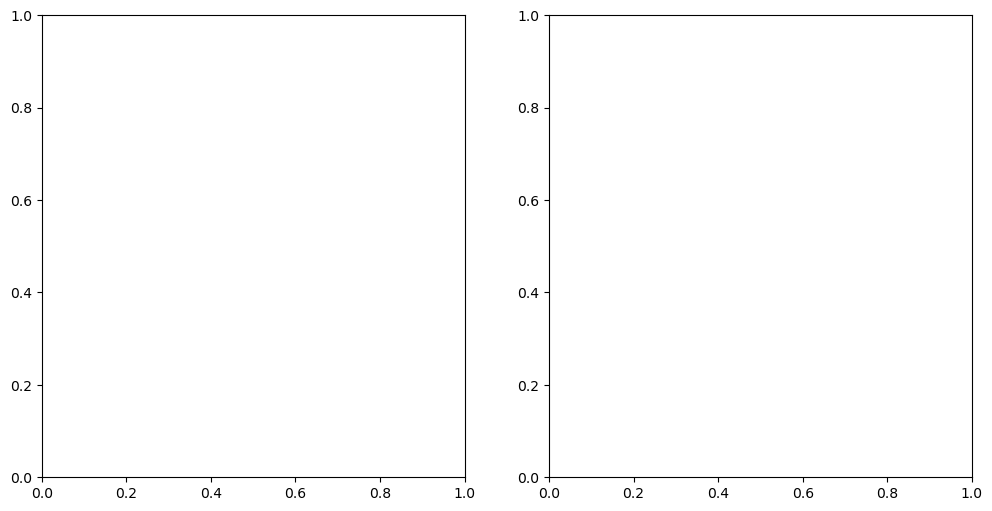

In [ ]:
from rulebook_benchmark.plotting import compare_realizations_gif
reason, human_pref, model_pref = incorrect[273]

human_traj = None
model_traj = None
for t in trajectories:
    if human_pref in t[0]:
        human_traj = t[1]
        
    if model_pref in t[0]:
        model_traj = t[1]
    
    if human_traj is not None and model_traj is not None:
        break
    
anim = compare_realizations_gif(model_traj, human_traj, reason, margin=50)

# play anim in jupyter notebook
display(HTML(anim.to_jshtml()))
    